In [ ]:
import dgl
import torch as th
# 创建一个具有3种节点类型和3种边类型的异构图
graph_data = {
   ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
   ('drug', 'interacts', 'gene'): (th.tensor([0, 1]), th.tensor([2, 3])),
   ('drug', 'treats', 'disease'): (th.tensor([1]), th.tensor([2]))
}
g = dgl.heterograph(graph_data)
print(g.ntypes)
print(g.etypes)
print(g.canonical_etypes)

In [ ]:
type(g.canonical_etypes[0])

In [ ]:
print(g)

In [ ]:
print(g.nodes('drug'))
print(g.nodes('gene'))
print(g.nodes('disease'))

In [ ]:
print(g.metagraph())

In [ ]:
g.num_nodes()

In [ ]:
# 设置/获取"drug"类型的节点的"hv"特征
g.nodes['drug'].data['hv'] = th.ones(3, 2)
g.nodes['drug'].data['hv']


In [ ]:
g.number_of_edges(g.canonical_etypes[0])

In [ ]:
# 设置/获取"treats"类型的边的"he"特征
g.edges[g.canonical_etypes[0]].data['he'] = th.zeros(1, 1)

In [ ]:
g.edges['treats'].data['he'] = th.ones(1, 1)
g.edges['treats'].data['he']

In [ ]:
g = dgl.heterograph({
   ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
   ('drug', 'is similar', 'drug'): (th.tensor([0, 1]), th.tensor([2, 3]))
})
print(g.nodes())
# 设置/获取单一类型的节点或边特征，不必使用新的语法
g.ndata['hv'] = th.ones(4, 1)

In [ ]:
g = dgl.heterograph({
   ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
   ('drug', 'treats', 'disease'): (th.tensor([1]), th.tensor([2]))})
g.nodes['drug'].data['hv'] = th.zeros(3, 1)
g.nodes['disease'].data['hv'] = th.ones(3, 1)
g.edges['interacts'].data['he'] = th.zeros(2, 2)
g.edges['treats'].data['he'] = th.zeros(1, 2)
# 默认情况下不进行特征合并
hg = dgl.to_homogeneous(g)
print('hv' in hg.ndata)
print('he' in hg.ndata)
# 拷贝边的特征
# 对于要拷贝的特征，DGL假定不同类型的节点或边的需要合并的特征具有相同的大小和数据类型
# hg = dgl.to_homogeneous(g, edata=['he'])
# 拷贝节点特征
hg = dgl.to_homogeneous(g, ndata=['hv'], edata=['he'])
print(hg.ndata['hv'])
print(hg.edata)

In [ ]:
g = dgl.heterograph({
   ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
   ('drug', 'interacts', 'gene'): (th.tensor([0, 1]), th.tensor([2, 3])),
   ('drug', 'treats', 'disease'): (th.tensor([1]), th.tensor([2]))
})
sub_g = dgl.edge_type_subgraph(g, [('drug', 'interacts', 'drug'),
                                   ('drug', 'interacts', 'gene')])
print(g)
print(sub_g)
# h_sub_g = dgl.to_homogeneous(sub_g)
# h_sub_g

In [ ]:
import dgl
import torch as th
u, v = th.tensor([0, 1, 2]), th.tensor([2, 3, 4])
g = dgl.graph((u, v))
g.ndata['x'] = th.randn(5, 3)   # 原始特征在CPU上
print(g.device)
cuda_g = g.to('cuda:0')         # 接受来自后端框架的任何设备对象
print(cuda_g.device)
print(cuda_g.ndata['x'].device)     # 特征数据也拷贝到了GPU上
# 由GPU张量构造的图也在GPU上
u, v = u.to('cuda:0'), v.to('cuda:0')
g = dgl.graph((u, v))
print(g.device)

In [55]:
import os

os.environ["DGLBACKEND"] = "pytorch"
###############################################################
# Readers can skip the following step-by-step explanation of the implementation and
# jump to the `Put everything together`_ for training and visualization results.
#
# To begin, you can get an overall impression about how a ``GATLayer`` module is
# implemented in DGL. In this section, the four equations above are broken down
# one at a time.
#
# .. note::
#
#    This is showing how to implement a GAT from scratch.  DGL provides a more
#    efficient :class:`builtin GAT layer module <dgl.nn.pytorch.conv.GATConv>`.
#

import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GATConv


class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain("relu")
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src["z"], edges.dst["z"]], dim=1)
        a = self.attn_fc(z2)
        return {"e": F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {"z": edges.src["z"], "e": edges.data["e"]}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox["e"], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox["z"], dim=1)
        return {"h": h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata["z"] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop("h")


##################################################################
# Equation (1)
# ^^^^^^^^^^^^
#
# .. math::
#
#   z_i^{(l)}=W^{(l)}h_i^{(l)},(1)
#
# The first one shows linear transformation. It's common and can be
# easily implemented in Pytorch using ``torch.nn.Linear``.
#
# Equation (2)
# ^^^^^^^^^^^^
#
# .. math::
#
#   e_{ij}^{(l)}=\text{LeakyReLU}(\vec a^{(l)^T}(z_i^{(l)}|z_j^{(l)})),(2)
#
# The un-normalized attention score :math:`e_{ij}` is calculated using the
# embeddings of adjacent nodes :math:`i` and :math:`j`. This suggests that the
# attention scores can be viewed as edge data, which can be calculated by the
# ``apply_edges`` API. The argument to the ``apply_edges`` is an **Edge UDF**,
# which is defined as below:


def edge_attention(self, edges):
    # edge UDF for equation (2)
    z2 = torch.cat([edges.src["z"], edges.dst["z"]], dim=1)
    a = self.attn_fc(z2)
    return {"e": F.leaky_relu(a)}


########################################################################3
# Here, the dot product with the learnable weight vector :math:`\vec{a^{(l)}}`
# is implemented again using PyTorch's linear transformation ``attn_fc``. Note
# that ``apply_edges`` will **batch** all the edge data in one tensor, so the
# ``cat``, ``attn_fc`` here are applied on all the edges in parallel.
#
# Equation (3) & (4)
# ^^^^^^^^^^^^^^^^^^
#
# .. math::
#
#   \begin{align}
#   \alpha_{ij}^{(l)}&=\frac{\exp(e_{ij}^{(l)})}{\sum_{k\in \mathcal{N}(i)}^{}\exp(e_{ik}^{(l)})},&(3)\\
#   h_i^{(l+1)}&=\sigma\left(\sum_{j\in \mathcal{N}(i)} {\alpha^{(l)}_{ij} z^{(l)}_j }\right),&(4)
#   \end{align}
#
# Similar to GCN, ``update_all`` API is used to trigger message passing on all
# the nodes. The message function sends out two tensors: the transformed ``z``
# embedding of the source node and the un-normalized attention score ``e`` on
# each edge. The reduce function then performs two tasks:
#
#
# * Normalize the attention scores using softmax (equation (3)).
# * Aggregate neighbor embeddings weighted by the attention scores (equation(4)).
#
# Both tasks first fetch data from the mailbox and then manipulate it on the
# second dimension (``dim=1``), on which the messages are batched.


def reduce_func(self, nodes):
    # reduce UDF for equation (3) & (4)
    # equation (3)
    alpha = F.softmax(nodes.mailbox["e"], dim=1)
    # equation (4)
    h = torch.sum(alpha * nodes.mailbox["z"], dim=1)
    return {"h": h}


#####################################################################
# Multi-head attention
# ^^^^^^^^^^^^^^^^^^^^
#
# Analogous to multiple channels in ConvNet, GAT introduces **multi-head
# attention** to enrich the model capacity and to stabilize the learning
# process. Each attention head has its own parameters and their outputs can be
# merged in two ways:
#
# .. math:: \text{concatenation}: h^{(l+1)}_{i} =||_{k=1}^{K}\sigma\left(\sum_{j\in \mathcal{N}(i)}\alpha_{ij}^{k}W^{k}h^{(l)}_{j}\right)
#
# or
#
# .. math:: \text{average}: h_{i}^{(l+1)}=\sigma\left(\frac{1}{K}\sum_{k=1}^{K}\sum_{j\in\mathcal{N}(i)}\alpha_{ij}^{k}W^{k}h^{(l)}_{j}\right)
#
# where :math:`K` is the number of heads. You can use
# concatenation for intermediary layers and average for the final layer.
#
# Use the above defined single-head ``GATLayer`` as the building block
# for the ``MultiHeadGATLayer`` below:


class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge="cat"):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == "cat":
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))


###########################################################################
# Put everything together
# ^^^^^^^^^^^^^^^^^^^^^^^
#
# Now, you can define a two-layer GAT model.


class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h


import networkx as nx

#############################################################################
# We then load the Cora dataset using DGL's built-in data module.

from dgl import DGLGraph
from dgl.data import citation_graph as citegrh


def load_cora_data():
    data = citegrh.load_cora()
    g = data[0]
    mask = torch.BoolTensor(g.ndata["train_mask"])
    return g, g.ndata["feat"], g.ndata["label"], mask


##############################################################################
# The training loop is exactly the same as in the GCN tutorial.

import time

import numpy as np

g, features, labels, mask = load_cora_data()


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 1.9490 | Time(s) nan
Epoch 00001 | Loss 1.9469 | Time(s) nan
Epoch 00002 | Loss 1.9449 | Time(s) nan
Epoch 00003 | Loss 1.9429 | Time(s) 0.2394
Epoch 00004 | Loss 1.9409 | Time(s) 0.2384
Epoch 00005 | Loss 1.9389 | Time(s) 0.2420
Epoch 00006 | Loss 1.9369 | Time(s) 0.2452
Epoch 00007 | Loss 1.9349 | Time(s) 0.2475
Epoch 00008 | Loss 1.9329 | Time(s) 0.2511
Epoch 00009 | Loss 1.9308 | Time(s) 0.2541
Epoch 00010 | Loss 1.9288 | Time(s) 0.2571
Epoch 00011 | Loss 1.9268 | Time(s) 0.2587
Epoch 00012 | Loss 1.9248 | Time(s) 0.2620
Epoch 00013 | Loss 1.9227 | Time(s) 0.2592
Epoch 00014 | Loss 1.9207 | Time(s) 0.2604
Epoch 00015 | Loss 1.9187 | Time(s) 0.2610
Epoch 00016 | Loss 1.9166 | Time(s) 0.2604
Epoch 00017 | Loss 1.9145 | Time(s) 0.2614
Epoch 00018 | Loss 1.9125 | Time(s) 0.2626
Epoch 0001

In [ ]:

# create the model, 2 heads, each head has hidden size 8
net = GAT(g, in_dim=features.size()[1], hidden_dim=8, out_dim=7, num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print(
        "Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), np.mean(dur)
        )
    )


In [56]:
data = citegrh.load_cora()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [59]:
data[0]

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})

In [100]:
from dgl.nn.pytorch import GraphConv
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)  # 定义第一层图卷积
        self.conv2 = GraphConv(hidden_dim, hidden_dim)  # 定义第二层图卷积
        self.classify = nn.Linear(hidden_dim, n_classes)   # 定义分类器

    def forward(self, g):
        print("###: ")
        print(g)
        print(g.ndata['feat'].shape)
        """g表示批处理后的大图，N表示大图的所有节点数量，n表示图的数量 
        """
        # 我们用节点的度作为初始节点特征。对于无向图，入度 = 出度
        # h = g.in_degrees().view(-1, 1).float() # [N, 1]
        h = g.ndata['feat']
        # 执行图卷积和激活函数
        h = F.relu(self.conv1(g, h))  # [N, hidden_dim]
        h = F.relu(self.conv2(g, h))  # [N, hidden_dim]
        g.ndata['h'] = h    # 将特征赋予到图的节点
        # 通过平均池化每个节点的表示得到图表示
        # hg = dgl.mean_nodes(g, 'h')   # [n, hidden_dim]
        # return self.classify(hg)  # [n, n_classes]
        return self.classify(h)


bz = 4
emb_dim = 5
evid_num = 5
batch_text_embs = torch.rand(bz, evid_num + 1, emb_dim)
batch_g = []
for i in range(bz):
    complete_g = nx.complete_graph(evid_num + 1)
    dgl_complete_g = dgl.from_networkx(complete_g)
    dgl_complete_g.ndata['feat'] = batch_text_embs[i]
    dgl_complete_g = dgl.add_self_loop(dgl_complete_g)
    # print(dgl_complete_g.num_edges())
    batch_g.append(dgl_complete_g)
batch_g = dgl.batch(batch_g)
# print(batch_g.edges())
# edge_num = batch_g.num_edges()
# mat = torch.zeros((edge_num, edge_num))
# u, v = batch_g.edges()
# mat[u, v] = 1

clf = Classifier(emb_dim, 20, 2)
outputs = clf(batch_g)
print(outputs.shape)

###: 
Graph(num_nodes=24, num_edges=144,
      ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float32)}
      edata_schemes={})
torch.Size([24, 5])
torch.Size([24, 2])


In [ ]:
g = dgl.comple(5)
print(g)

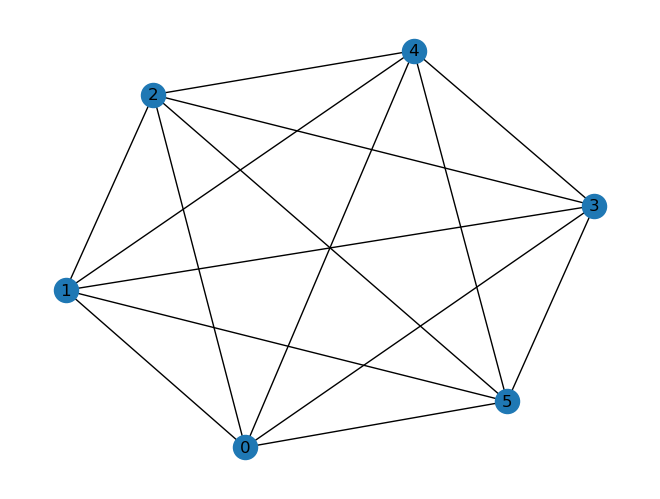

In [63]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个包含6个节点的完全图
num_nodes = 6
complete_graph = nx.complete_graph(num_nodes)

# 绘制图形
nx.draw(complete_graph, with_labels=True)
plt.show()


In [7]:
import torch

embs = torch.rand(10, 15).requires_grad_()
evid_emb = embs[3:7, :]
res = torch.sum(evid_emb)
print(evid_emb.shape)
res.backward()
print(embs.grad)

torch.Size([4, 15])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
